In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import List, Tuple, Dict, Optional
import numpy as np
import seaborn as sns
from datetime import datetime
import requests
from dotenv import load_dotenv


In [55]:
load_dotenv()

BACKEND_USER = os.environ['BACKEND_USER']
BACKEND_PASSWORD = os.environ['BACKEND_PASSWORD']
BACKEND_URL = os.environ['BACKEND_URL']
BACKEND_URL = 'http://localhost:5050'
BACKEND_USER = 'admin'
BACKEND_PASSWORD = 'admin'

experiment_type = 'reward-network-iii-6A-v2'
experiment_type = 'reward-network-iii-6B-v1'
experiment_type = 'reward-network-iii-7B-v1'
experiment_type = 'reward-network-iii-8B-v1'
experiment_type = 'reward-network-iii-8A-v1'
experiment_type = 'test2'


finished = True


In [75]:
from common.utils.utils import estimate_solution_score, estimate_average_player_score
from common.models.network import Network


url = f'{BACKEND_URL}/results'
headers = {'Accept': 'application/json'}
auth = (BACKEND_USER, BACKEND_PASSWORD)
current_datatime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# #---subjects----
subjects = requests.get(f'{url}/subjects', headers=headers, auth=auth)
subjects_df = pd.DataFrame(subjects.json())
s_to_p = subjects_df.set_index('session_id')['prolific_id'].to_dict()

#---sessions----
sessions = requests.get(f'{url}/sessions?experiment_type={experiment_type}&finished={finished}', headers=headers, auth=auth)
sessions_json = sessions.json()



def eval_move(edge, all_edges):
    max_reward = max([e['reward'] for e in all_edges])
    min_reward = min([e['reward'] for e in all_edges])

    myopic = edge['reward'] == max_reward
    has_large_loss = min_reward == -50
    large_loss_taken = edge['reward'] == -50

    optimal = large_loss_taken if has_large_loss else myopic

    return {
        'myopic': myopic,
        'optimal': optimal,
        'large_loss_taken': large_loss_taken,
    }



def get_moves(network: dict, moves_nodes: List[int], correct_repeats: Optional[List[bool]] = None):
    edges_by_source = {}
    for edge in network['edges']:
        edges_by_source.setdefault(edge['source_num'], []).append(edge)

    edges_by_source_target = {
        source_num: {
            edge['target_num']: edge
            for edge in edges
        }
        for source_num, edges in edges_by_source.items()
    }


    nodes_by_num = {
        node['node_num']: node
        for node in network['nodes']
    }

    moves = []
    for i, (source_num, target_num) in enumerate(zip(moves_nodes[:-1], moves_nodes[1:])):
        edges = edges_by_source_target[source_num]
        edge = edges[target_num]
        moves.append({
            "move_idx": i,
            "source_num": source_num,
            "target_num": target_num,
            "reward": edge['reward'],
            "level": nodes_by_num[target_num]['level'],
            "correct_repeat": correct_repeats[i] if correct_repeats is not None else None,
            **eval_move(edge, edges.values())
        })
    return moves


written_strategies = []
p_moves = []
for session in sessions_json:
    for trial in session['trials']:
        if trial['solution'] is not None:
            pid = s_to_p.get(session['_id'])
            is_ai = session['ai_player']
            score = estimate_solution_score(Network(**trial['network']), trial['solution']['moves'], n_steps=10)
            assert score > 0, f"negative score {score} in session {session['_id']} for {trial['id']} of type {trial['trial_type']} pid {pid} ai {is_ai}"

            moves = get_moves(trial['network'], trial['solution']['moves'], trial['solution']['correctRepeats'])
            trials_info = {
                'session_id': session['_id'],
                'trial_id': trial['id'],
                'trial_type': trial['trial_type'],
                'score': trial['solution']['score'],
                'average_score': session['average_score'],
            }
            moves = [{**m, **trials_info} for m in moves]
            p_moves.extend(moves)
        if trial['written_strategy'] is not None and session['ai_player'] is False:
            written_strategies.append({
                'session_id': session['_id'],
                'trial_id': trial['id'],
                'text': trial['written_strategy']['strategy'],
            })


moves_df = pd.DataFrame(p_moves)
strategy_df = pd.DataFrame(written_strategies)

trials_df = pd.DataFrame([{**t, 'session_id': s['_id']} for s in sessions_json for t in s['trials']])
sessions_df = pd.DataFrame([{k: v for k, v in s.items() if k != 'trials'} for s in sessions_json])
session_idx = {s: i for i, s in enumerate(moves_df['session_id'].unique())}
trial_idx = {s: i for i, s in enumerate(moves_df['trial_id'].unique())}
wr_trial_idx = {s: i for i, s in enumerate(strategy_df['trial_id'].unique())}


moves_df['session_idx'] = moves_df['session_id'].apply(lambda x: session_idx[x])
sessions_df['session_idx'] = sessions_df['_id'].apply(lambda x: session_idx[x])
moves_df['trial_idx'] = moves_df['trial_id'].apply(lambda x: trial_idx[x])
moves_df = moves_df.merge(
    sessions_df[['session_idx', 'generation', 'session_num_in_generation', 'ai_player', 'simulated_subject']],
    on='session_idx', how='left')

strategy_df['session_idx'] = strategy_df['session_id'].apply(lambda x: session_idx[x])
strategy_df['ws_idx'] = strategy_df['trial_id'].apply(lambda x: wr_trial_idx[x])

strategy_df = strategy_df.sort_values(by=['session_idx', 'ws_idx'])


# create folder
os.makedirs(os.path.join('./data/pilots/',experiment_type), exist_ok=True)

strategy_df.to_csv(os.path.join('./data/pilots/',experiment_type,'strategy.csv'), index=False)
moves_df.to_csv(os.path.join('./data/pilots/',experiment_type,'moves.csv'), index=False)
trials_df.to_csv(os.path.join('./data/pilots/',experiment_type,'trials.csv'), index=False)


In [61]:

# df = moves_df.copy()

# df = df.sort_values(by=['average_score'])

# df = df[df['trial_type'].isin(['repeat'])]

# moves_matrix = df.pivot_table(index=['average_score', 'session_idx', 'move_idx'], columns=['trial_idx'], values='correct_repeat')
# n_sessions = len(moves_matrix.index.levels[0])

# # Original nodes and colors
# nodes = np.array([-50, 0, 400])
# colors = ["red", "yellow", "green"]

# # Normalize nodes to be in the range [0, 1]
# norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
# cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))

# plt.figure(figsize=(8, n_sessions))

# sns.heatmap(moves_matrix, cmap=cmap, cbar=False)


<Axes: xlabel='trial_idx', ylabel='session_name'>

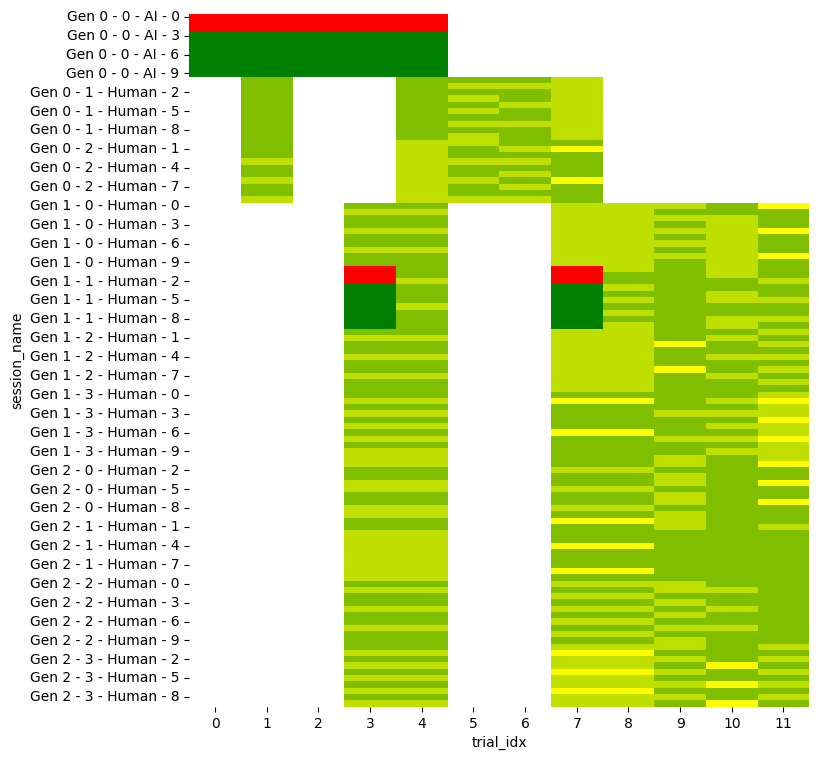

In [90]:
ai_str = np.where(moves_df['ai_player'], 'AI', 'Human')
moves_df['session_name'] = 'Gen ' + moves_df['generation'].astype(str) + ' - ' + moves_df['session_num_in_generation'].astype(str) + ' - ' + ai_str + ' - ' + moves_df['move_idx'].astype(str)


moves_matrix = moves_df.pivot_table(index=['average_score', 'session_name', 'move_idx'], columns=['trial_idx'], values='reward')
n_sessions = len(moves_matrix.index.levels[0])

# drop all index but session_name
moves_matrix = moves_matrix.reset_index(level=[0,2], drop=True)

moves_matrix = moves_matrix.sort_index(level=0, ascending=True)

# Original nodes and colors
nodes = np.array([-50, 0, 400])
colors = ["red", "yellow", "green"]

# Normalize nodes to be in the range [0, 1]
norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))

plt.figure(figsize=(8, n_sessions))

sns.heatmap(moves_matrix, cmap=cmap, cbar=False, vmin=-50, vmax=400)


In [83]:
moves_matrix

trial_idx,average_score,session_name,0,1,2,3,4,5,6,7,8,9,10,11
move_idx,,,,,,,,,,,,,,
0,1433,Gen 1 - 3 - Human,NaN,NaN,NaN,200.0,200.0,NaN,NaN,200.0,200.0,200.0,200.0,100.0
1,1433,Gen 1 - 3 - Human,NaN,NaN,NaN,100.0,100.0,NaN,NaN,0.0,0.0,200.0,100.0,0.0
2,1433,Gen 1 - 3 - Human,NaN,NaN,NaN,200.0,200.0,NaN,NaN,200.0,200.0,200.0,200.0,100.0
3,1433,Gen 1 - 3 - Human,NaN,NaN,NaN,100.0,100.0,NaN,NaN,200.0,200.0,100.0,100.0,100.0
4,1433,Gen 1 - 3 - Human,NaN,NaN,NaN,200.0,200.0,NaN,NaN,200.0,200.0,200.0,200.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2650,Gen 0 - 0 - AI,400.0,400.0,400.0,400.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2650,Gen 0 - 0 - AI,400.0,400.0,400.0,400.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2650,Gen 0 - 0 - AI,400.0,400.0,400.0,400.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='trial_idx', ylabel='session_idx'>

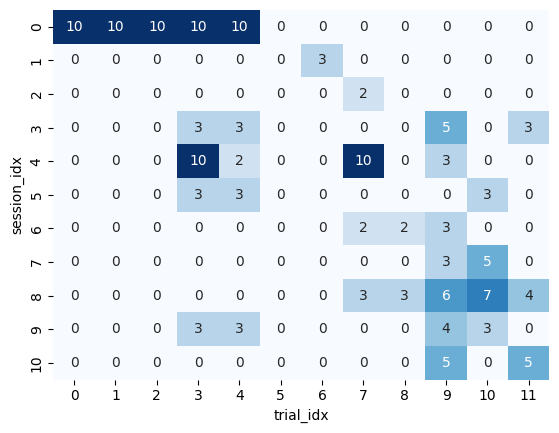

In [63]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trial_idx'], values='optimal', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trial_idx', ylabel='session_idx'>

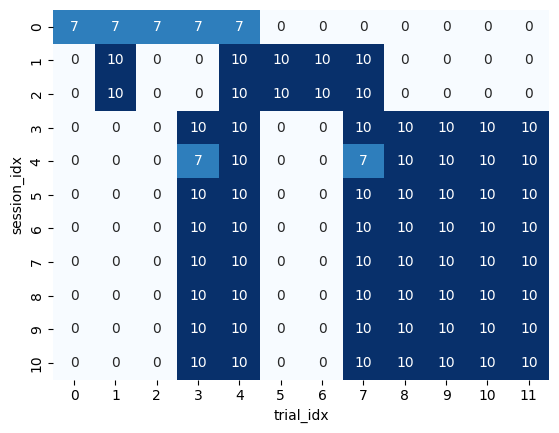

In [64]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trial_idx'], values='myopic', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trial_idx', ylabel='session_idx'>

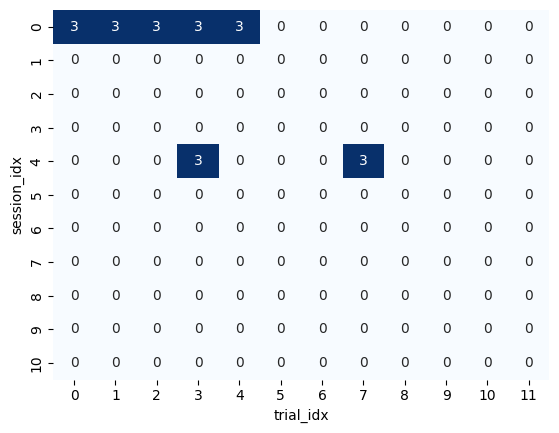

In [65]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trial_idx'], values='large_loss_taken', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


In [66]:
# large_loss_taken, myopic, optimal

moves_behavior = moves_df.melt(id_vars=['session_idx', 'trial_idx'], value_vars=['large_loss_taken', 'myopic', 'optimal'], var_name='behavior', value_name='count')


<Axes: xlabel='trial_idx', ylabel='count'>

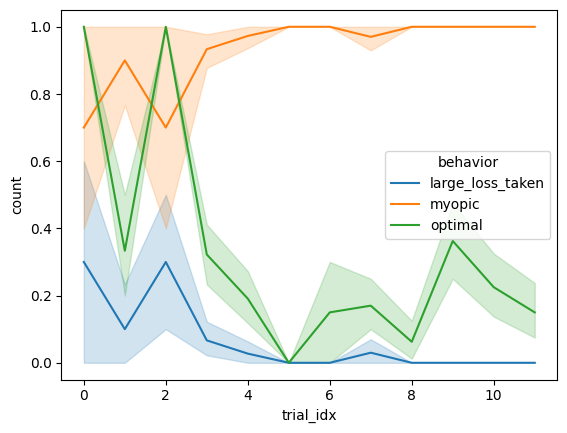

In [67]:
sns.lineplot(data=moves_behavior, x='trial_idx', y='count', hue='behavior')


<Axes: xlabel='trial_idx', ylabel='reward'>

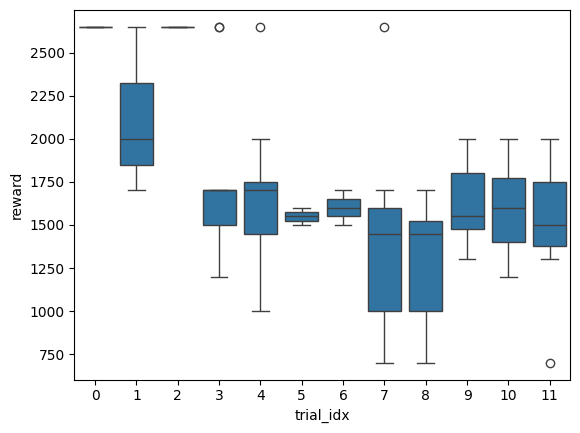

In [68]:
df_group = moves_df.groupby(['session_idx', 'trial_idx'])['reward'].sum().reset_index()

sns.boxplot(data=df_group, x='trial_idx', y='reward')


In [69]:
trials_df[trials_df['trial_type'] == 'written_strategy']['written_strategy'].iloc[0]


{'strategy': '', 'trial_id': None, 'finished_at': None}